## Import Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from PIL import Image
from pathlib import Path
from rich import inspect

import torch
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# rcg
import util.misc as misc
from config import RCGConfiguration
from engine_mage import gen_img
from pixel_generator.mage import models_mage
from rdm.util import instantiate_from_config

%matplotlib inline


In [2]:
# rtk
from rtk._datasets import create_transforms
from rtk.config import *
from rtk.datasets import instantiate_image_dataset
from rtk.mlflow import prepare_mlflow
from rtk.repl import prepare_console
from rtk.utils import get_logger, hydra_instantiate, _strip_target

ws, console = prepare_console(show_locals=False, _traceback=False)

2024-02-18 22:24:30,245 - Found the config file in: /home/nicoleg/workspaces/rcg/config.json


In [3]:
init_method_kwargs = {"config_dir": "/home/nicoleg/workspaces/rcg/config/"}
overrides = [
    "device=1",
    "datasets.preprocessing.positive_class=null",
    "datasets.target=class_conditioned_labels",
    "datasets/encoding=class-conditioned-encoding",
    "datasets/transforms=rdm-transforms",
]
config_name = "rdm"

In [4]:
args: RCGConfiguration = set_hydra_configuration(
    config_name,
    ConfigurationInstance=RCGConfiguration,
    init_method_kwargs=init_method_kwargs,
    overrides=overrides,
)
console.print(args)

[22:24:31] INFO     rtk.config: Creating configuration: 'rdm'                                         ]8;id=161950;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/config.py\config.py]8;;\:]8;id=190635;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/config.py#134\134]8;;\
                    [0m                                                                                            

RCGConfiguration(
    datasets={'name': 'cxr14', 'dim': 224, 'extension': '.png', 'index': 'Image Index', 'labels': None, 'target': 
'class_conditioned_labels', 'patient_data': 'cxr14_metadata', 'patient_data_version': 2, 'scan_data': 
'/home/nicoleg/workspaces/dissertation/.data/CHEST_XRAY_14/', 'dataloader': {'_target_': 
'monai.data.ThreadDataLoader', 'batch_size': 16, 'num_workers': 24}, 'instantiate': {'_target_': 
'monai.data.ImageDataset'}, 'keys': {'image_files': 'image_files', 'labels': 'labels'}, 'encoding': {'No Finding': 
0, 'Pneumonia (m)': 1, 'Pneumonia (s)': 2, 'Other': 3}, 'preprocessing': {'positive_class': None, 'use_sampling': 
True, 'sampling_method': {'sample_to_value': 3500, 'method': {'_dir_': 
'/home/nicoleg/workspaces/dissertation/.data/Generated_Datasets/2024-02-08_10-22-26'}}}, 'text_prompts': 
{'class_prompts': {0: 'healthy lungs', 1: 'Pneumonia with other common thorax diseases in the lungs', 2: 'Pneumonia
in the lungs', 3: 'other common thorax diseases without Pneumonia in the lungs'}, 'negative_prompts': 
['colorful']}, 'transforms': {'load': [{'_target_': 'monai.transforms.EnsureChannelFirst'}, {'_target_': 
'monai.transforms.Resize', 'spatial_size': ['${datasets.dim}', '${datasets.dim}']}], 'train': [{'_target_': 
'torchvision.transforms.RandomCrop', 'size': '${datasets.dim}'}, {'_target_': 
'torchvision.transforms.RandomHorizontalFlip'}]}},
    mlflow={'experiment_name': '${experiment_name}', 'start_run': {'experiment_id': None, 'run_name': 
'rdm-${now:%Y-%m-%d-%H-%M-%S}', 'log_system_metrics': True}},
    experiment_name='rcg-experiments',
    date='2024-02-18',
    postfix='',
    timestamp='22-24-31',
    mode='diffusion',
    output_dir='outputs',
    log_dir='logs',
    device=1,
    use_transforms=True,
    random_state=42,
    seed=42,
    class_cond=True,
    num_images=3500,
    batch_size=16,
    epochs=100,
    accum_iter=1,
    input_size=256,
    config='/home/nicoleg/workspaces/rcg/config/rdm/mocov3vitb_simplemlp_l12_w1536_classcond.yaml',
    pretrained_rdm_cfg='',
    pretrained_rdm_ckpt='',
    weight_decay=0.05,
    lr=None,
    blr=1e-05,
    min_lr=0.0,
    cosine_lr=True,
    warmup_epochs=0,
    resume='',
    start_epoch=0,
    num_workers=24,
    pin_mem=True,
    evaluate=False,
    use_ddim=False,
    distributed=False,
    world_size=1,
    local_rank=-1,
    dist_on_itp=False,
    dist_url='env://'
)

## Load pre-trained encoder, RDM and MAGE

In [5]:
from omegaconf import OmegaConf
from rdm.models.diffusion.ddpm import RDM

# Initialize RCG-L
class_cond = False
# rdm_ckpt_path = "outputs/rdm/2024-02-01/16-00-35/outputs/checkpoint-last.pth"
rdm_ckpt_path = "/home/nicoleg/workspaces/rcg/outputs/rdm/2024-02-14/00-33-44/outputs/checkpoint-last.pth"
rdm_cfg = "config/rdm/mocov3vitb_simplemlp_l12_w1536_classcond.yaml"
model = models_mage.mage_vit_large_patch16(
    mask_ratio_mu=0.75,
    mask_ratio_std=0.25,
    mask_ratio_min=0.5,
    mask_ratio_max=1.0,
    vqgan_ckpt_path="pretrained_enc_ckpts/vqgan_jax_strongaug.ckpt",
    use_rep=True,
    rep_dim=256,
    rep_drop_prob=0.1,
    use_class_label=False,
    pretrained_enc_arch="mocov3_vit_base",
    pretrained_enc_path="pretrained_enc_ckpts/mocov3/vitb.pth.tar",
    pretrained_enc_proj_dim=256,
    pretrained_enc_withproj=True,
    pretrained_rdm_ckpt=rdm_ckpt_path,
    pretrained_rdm_cfg=rdm_cfg,
)
# config = OmegaConf.load(args.config)
# model: RDM = instantiate_from_config(config.model)
model.cuda();

Use representation as condition!
Loading model from /home/nicoleg/workspaces/rcg/outputs/rdm/2024-02-14/00-33-44/outputs/checkpoint-last.pth
RDM: Running in x0-prediction mode
DiffusionWrapper has 72.18 M params.
Keeping EMAs of 156.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Strict load
Restored from pretrained_enc_ckpts/vqgan_jax_strongaug.ckpt


In [6]:
# checkpoint = torch.load(args.pretrained_rdm_ckpt, map_location='cpu')
# model.load_state_dict(checkpoint['model'], strict=True)
# model.eval();

## Image Generation

In [7]:
from rtk.datasets import set_labels_from_encoding

torch.manual_seed(args.seed)
np.random.seed(args.seed)

n_image_to_gen = 1
rdm_steps = 250
rdm_eta = 1.0
mage_temp = 11.0
mage_steps = 20
cfg = 6.0

In [8]:
dataset_cfg = args.datasets
labels = set_labels_from_encoding(args)
class_encoding = {v: k for k, v in dataset_cfg.encoding.items()}
class_encoding

{0: 'No Finding', 1: 'Pneumonia (m)', 2: 'Pneumonia (s)', 3: 'Other'}

In [9]:
def viz_torchimage(image: torch.Tensor):
    image = torch.clamp(image, 0, 1)
    image_np = image.detach().cpu().numpy().transpose([1, 2, 0])
    image_np = Image.fromarray(np.uint8(image_np * 255))
    display(image_np)

Generating: 'No Finding'...

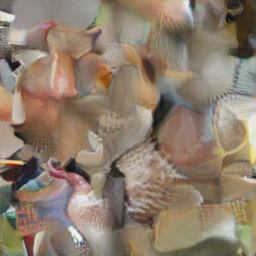

Generating: 'Pneumonia (m)'...

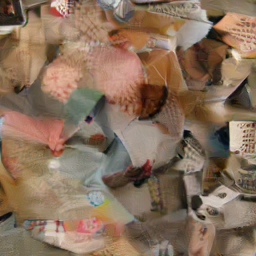

Generating: 'Pneumonia (s)'...

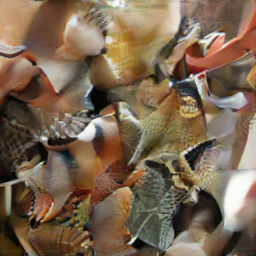

Generating: 'Other'...

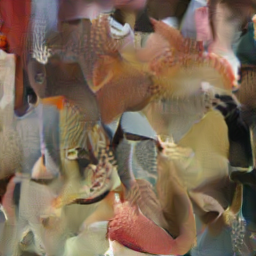

In [18]:
images = []
labels = dataset_cfg.labels

for class_label in class_encoding.keys():
    label = class_encoding[class_label]
    console.print("Generating: '{}'...".format(label))
    class_label = class_label * torch.ones(1).cuda().long()
    for i in range(n_image_to_gen):
        gen_images, lab = model.gen_image(
            1,
            num_iter=mage_steps,
            choice_temperature=mage_temp,
            sampled_rep=None,
            rdm_steps=rdm_steps,
            eta=rdm_eta,
            cfg=cfg,
            class_label=class_label,
        )
        viz_torchimage(gen_images[0])
        # images.append(img)

# fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# for i, ax in enumerate(axs.flat):
#     ax.imshow(images[i])
#     ax.axis("off")  # to hide the axes

In [11]:
datasets = instantiate_image_dataset(args)
test_dataset = datasets[-1]

[22:24:52] INFO     rtk.datasets: Instantiating image dataset...[0m                                 ]8;id=966145;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/datasets.py\datasets.py]8;;\:]8;id=81239;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/datasets.py#278\278]8;;\

2024-02-18 22:24:52,441 - Found the config file in: /home/nicoleg/workspaces/rcg/config.json


[22:24:53] INFO     rtk.utils: Patient dataset:             'cxr14_metadata'[0m                        ]8;id=632284;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/utils.py\utils.py]8;;\:]8;id=48756;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/utils.py#128\128]8;;\

[22:24:53] INFO     rtk.config: Creating 'train' transforms...[0m                                    ]8;id=593040;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/_datasets/__init__.py\__init__.py]8;;\:]8;id=319542;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/_datasets/__init__.py#29\29]8;;\

           INFO     rtk.config: Creating 'eval' transforms...[0m                                     ]8;id=765602;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/_datasets/__init__.py\__init__.py]8;;\:]8;id=775172;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/_datasets/__init__.py#31\31]8;;\

[22:24:53] INFO     rtk.datasets: Image dataset instantiated.                                       ]8;id=69004;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/datasets.py\datasets.py]8;;\:]8;id=702121;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/datasets.py#306\306]8;;\
                    [0m                                                                                            

In [12]:
from collections import Counter

Counter(test_dataset.labels)

Counter({2: 467, 1: 88, 3: 15180, 0: 9861})

In [13]:
from monai.data import ThreadDataLoader

loader = ThreadDataLoader(test_dataset, batch_size=1, num_workers=12, shuffle=True)
iter_loader = iter(loader)

In [14]:
scans, labels = next(iter_loader)

In [15]:
scans.shape, labels

((1, 3, 224, 224), tensor([3]))

## GT Representation Reconstruction

### Generate Image from GT Representation

Ground Truth Image:
2024-02-18 22:25:26,139 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 4096])

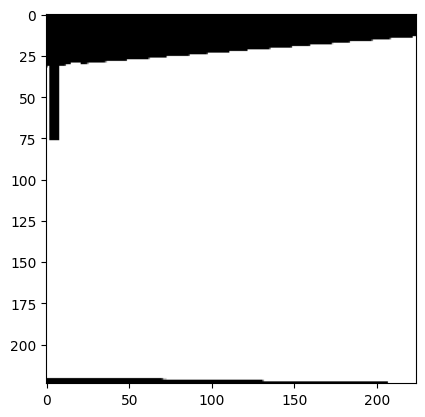

In [17]:
n_image_to_gen = 1
rdm_steps = 250
rdm_eta = 1.0
mage_temp = 11.0
mage_steps = 20
cfg = 0.0

images, _ = next(iter_loader)

images = images.cuda()
print("Ground Truth Image:")
plt.imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)), cmap="bone")

with torch.no_grad():
    mean = (
        torch.Tensor([0.485, 0.456, 0.406])
        .cuda()
        .unsqueeze(0)
        .unsqueeze(-1)
        .unsqueeze(-1)
    )
    std = (
        torch.Tensor([0.229, 0.224, 0.225])
        .cuda()
        .unsqueeze(0)
        .unsqueeze(-1)
        .unsqueeze(-1)
    )
    x_normalized = (images - mean) / std
    x_normalized = torch.nn.functional.interpolate(x_normalized, 224, mode="bicubic")
    rep = model.pretrained_encoder.forward_features(x_normalized)
    if model.pretrained_enc_withproj:
        rep = model.pretrained_encoder.head(rep)
    rep_std = torch.std(rep, dim=1, keepdim=True)
    rep_mean = torch.mean(rep, dim=1, keepdim=True)
    rep = (rep - rep_mean) / rep_std

print("Reconstructed Images:")
recon_image_list = []
for _ in range(n_image_to_gen):
    recon_images, _ = model.gen_image(
        12,
        num_iter=mage_steps,
        choice_temperature=mage_temp,
        sampled_rep=rep,
        rdm_steps=rdm_steps,
        eta=rdm_eta,
        cfg=cfg,
        class_label=None,
    )
    viz_torchimage(recon_images[0].cpu().numpy())